In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aer-credit-card-data/AER_credit_card_data.csv


In [2]:
data = pd.read_csv('/kaggle/input/aer-credit-card-data/AER_credit_card_data.csv')

In [3]:
data

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


Decision Tree

In [4]:
class Node():
    def __init__(self, feature_index = None, threshold = None, left = None, right = None, info_gain = None, value = None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain

        self.value = value

In [5]:
import numpy as np

class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value

class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.feature_types = None  # To store feature types (numeric/categorical)

    def build_tree(self, dataset, curr_depth=0):
        X = dataset[:, :-1]  # All columns except last
        Y = dataset[:, -1]   # Last column is target
        num_samples, num_features = np.shape(X)

        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            
            if best_split["info_gain"] > 0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"], 
                          left_subtree, right_subtree, best_split["info_gain"])

        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        max_info_gain = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            
            # Determine if feature is numeric or categorical
            try:
                feature_values.astype(float)
                is_numeric = True
                possible_thresholds = np.unique(feature_values)
            except ValueError:
                is_numeric = False
                possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold, is_numeric)

                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")

                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        return best_split

    def split(self, dataset, feature_index, threshold, is_numeric):
        feature_col = dataset[:, feature_index]
        if is_numeric:
            feature_col = feature_col.astype(float)
            mask = feature_col <= threshold
        else:
            mask = feature_col == threshold
            
        dataset_left = dataset[mask]
        dataset_right = dataset[~mask]
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == "gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            if p_cls > 0:
                entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)
        else:
            print("X_"+str(tree.feature_index), "<=" if isinstance(tree.threshold, (int, float)) else "==", 
                  tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        if isinstance(Y[0], str):
            Y = np.array([1 if y == 'yes' else 0 for y in Y])
        
        Y = Y.reshape(-1, 1) if len(Y.shape) == 1 else Y
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions

    def make_prediction(self, x, tree):
        if tree.value is not None: 
            return tree.value
        feature_val = x[tree.feature_index]
        
        try:
            feature_val = float(feature_val)
            threshold = float(tree.threshold)
            if feature_val <= threshold:
                return self.make_prediction(x, tree.left)
            else:
                return self.make_prediction(x, tree.right)
        except ValueError:
            if feature_val == tree.threshold:
                return self.make_prediction(x, tree.left)
            else:
                return self.make_prediction(x, tree.right)
                

In [6]:
X = data.iloc[:, 1:].values
Y = data.iloc[:, 1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [7]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
classifier.print_tree()

X_0 <= 0 ? 0.2145257812648483
 left:0
 right:X_0 <= 1 ? 0.30251077308978636
  left:1
  right:X_0 <= 2 ? 0.2858339137067623
    left:2
    right:X_0 <= 3 ? 0.27757258643685245
        left:3
        right:4


In [8]:
Y_pred = classifier.predict(X_test) 
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9734848484848485

Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for column in ['card', 'owner', 'selfemp']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

X = data.drop('card', axis=1)
y = data['card']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(
    n_estimators=100,      
    max_depth=10,           
    min_samples_split=5,    
    min_samples_leaf=2,     
    max_features='sqrt',    
    bootstrap=True,         
    random_state=42,        
    n_jobs=-1              
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9734848484848485

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95        62
           1       0.99      0.97      0.98       202

    accuracy                           0.97       264
   macro avg       0.95      0.98      0.96       264
weighted avg       0.98      0.97      0.97       264


Confusion Matrix:
[[ 61   1]
 [  6 196]]


In [10]:
importances = rf.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance)


Feature Importances:
        Feature  Importance
3         share    0.452090
4   expenditure    0.412023
0       reports    0.070352
2        income    0.015379
10       active    0.014420
1           age    0.013551
8        months    0.009732
7    dependents    0.004602
5         owner    0.004264
9    majorcards    0.002582
6       selfemp    0.001004


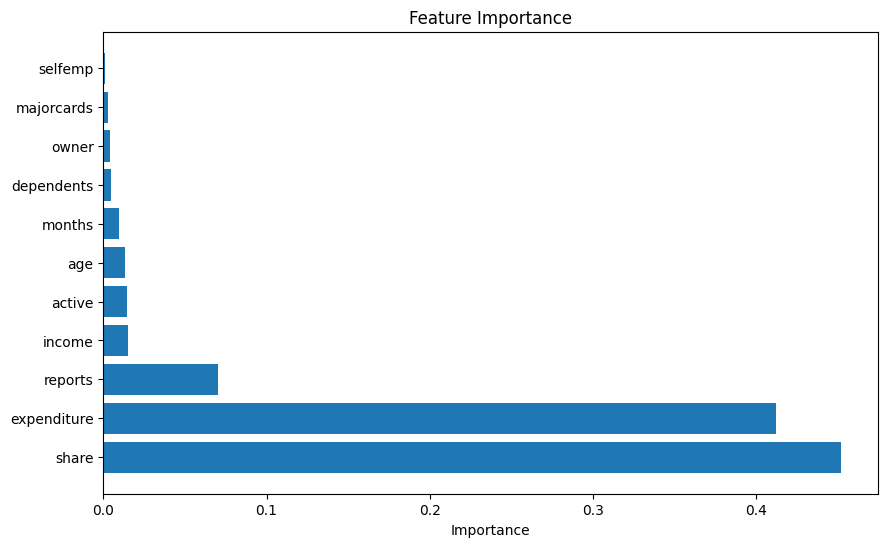

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()